## Racetrack (5.12)

Action space is determined by adjustments to vertical and horizontal velocities

In [1]:
import itertools

actions_horizontal = [-1,0,1]
actions_vertical = [-1,0,1]
action_space = list(itertools.product(actions_horizontal, actions_vertical))
print(f"Action space is: {len(action_space)} dimensional")
action_space

Action space is: 9 dimensional


[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]

To visualize the problem, we generate a racetrack of 31 x 15 space. We consider the top part to be the starting line and the bottom right the finish line

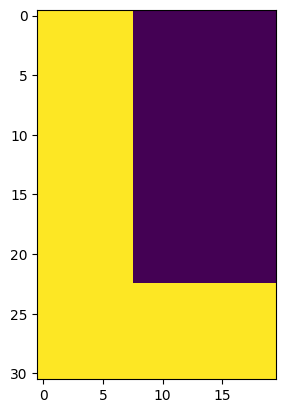

In [30]:
import matplotlib.pyplot as plt
import numpy as np


def create_racetrack(rows, columns, lanewidth):
    racetrack = np.ones((rows, columns), dtype=np.uint8)
    racetrack[:rows-lanewidth,lanewidth:] = 0
    return racetrack

racetrack_ex = create_racetrack(31,20,8)
plt.imshow(racetrack_ex)
plt.show()

Let's simulate a starting position at (0,3) which is the bottom of the map. Valid runway is shown in yellow with sample starting position represented in the red dot

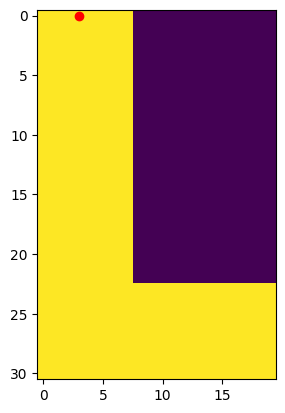

In [32]:
# We need this helper function to plot the dot over the racetrack considering that
# the plt.imshow inverts the coordinate of reference
def plot_dot_over_racetrack(row, column, racetrack):
  plt.imshow(racetrack)
  plt.plot(column, row, 'ro')
  plt.show()

start_pos_ex = (0,3)
plot_dot_over_racetrack(*start_pos_ex, racetrack_ex)

We can implement functions for getting the next position of the car based on its current velocity and position. So, for the previous starting position and a velocity of (0,0) this leads to the following

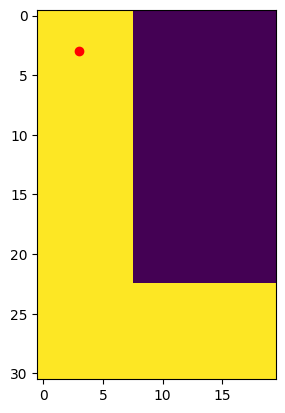

In [35]:
def next_position(pos_row, pos_column, vel_row, vel_col):
    return pos_row + vel_row, pos_column + vel_col

next_pos_ex = next_position(*start_pos_ex,3,0)
plot_dot_over_racetrack(*next_pos_ex, racetrack_ex)

It is also helpful to have a way to know if the next position, based on current position and velocity, would lead to a boundary crash. Following the previous example, if we had a velocity of (0, 5) following the last position, it would crash with the boundary.

In [42]:
def check_if_crash(pos_row, pos_column, vel_row, vel_column, racetrack):
  next_row, next_col = next_position(pos_row, pos_column, vel_row, vel_column)
  in_x_scope = next_row < racetrack.shape[0] and next_row >= 0
  in_y_scope = next_col < racetrack.shape[1] and next_col >= 0
  if not in_x_scope or not in_y_scope:
    return True
  return not bool(racetrack[next_row][next_col])

crash_ex = check_if_crash(*next_pos_ex, 0, 5, racetrack_ex)
print(f"Car at position {next_pos_ex} moved by velocity (0,5) crashes? {crash_ex}")
not_crash_ex = check_if_crash(*next_pos_ex,0,2, racetrack_ex)
print(f"Car at position {next_pos_ex} moved by velocity (0,2) crashes? {not_crash_ex}")

Car at position (3, 3) moved by velocity (0,5) crashes? True
Car at position (3, 3) moved by velocity (0,2) crashes? False


In [ ]:
X_TOTAL = 15
Y_TOTAL = 30
X_BARRIER = 6
Y_BARRIER = 25

# state: [x,y,v_x,v_y]
# action: [a_x,a_y]
# return [reward, new_x, new_y, new_v_x, new_v_y]
def next_step(state: tuple[int,int,int,int], action:tuple[int,int]) -> tuple[int]:
    x_new = state[0] + state[2] + action[0]
    y_new = state[1] + state[3] + action[1]
    # bump into top or left wall
    if x_new < 0 or y_new < 0:
        return (0, np.random.randint(0,X_BARRIER),0,0,0)
    # bump into right wall
    elif x_new >= X_BARRIER and y_new <= Y_BARRIER:
        return (0, np.random.randint(0,X_BARRIER),0,0,0)
    # bump into top wall of bottom channel
    elif x_new >= X_BARRIER and y_new <= Y_BARRIER:
        return (0, np.random.randint(0,X_BARRIER),0,0,0)
    # bump into bottom wall
    elif y_new > Y_TOTAL:
        return (0, np.random.randint(0,X_BARRIER),0,0,0)
    elif x_new >= X_TOTAL and y_new <= Y_TOTAL and y_new > Y_BARRIER:
        return (1,0,0,0,0)
    else:
        return (-1, x_new, y_new, state[2]+action[0], state[3]+action[1])

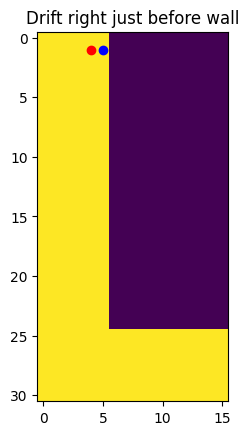

In [ ]:
# test state in position x=0, y=1 with velocity v_x=0, v_y=1
start_state = (4,1,1,0)
# drift to just before right wall
out =  next_step(start_state,(0,0))
plt.imshow(state_space)
plt.plot(start_state[0],start_state[1],'ro')
plt.plot(out[1],out[2],'bo')
plt.title("Drift right just before wall")
plt.show()
#

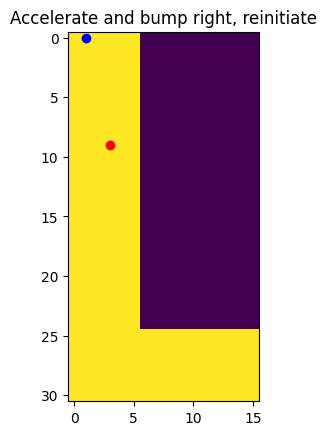

In [ ]:
# accelerate to right wall and reinitiate
start_state = (3,9,3,0)
out =  next_step(start_state,(1,0))
plt.imshow(state_space)
plt.plot(*start_state[:2],'ro')
plt.plot(out[1],out[2],'bo')
plt.title("Accelerate and bump right, reinitiate")
plt.show()

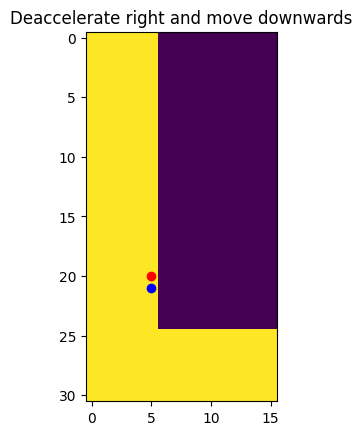

In [ ]:
# deaccelerate and avoid bumping into wall, move downwards
start_state = (5,20,1,0)
out =  next_step(start_state,(-1,1))
plt.imshow(state_space)
plt.plot(*start_state[:2],'ro')
plt.plot(out[1],out[2],'bo')
plt.title("Deaccelerate right and move downwards")
plt.show()
assert out == (-1,5,21,0,1)

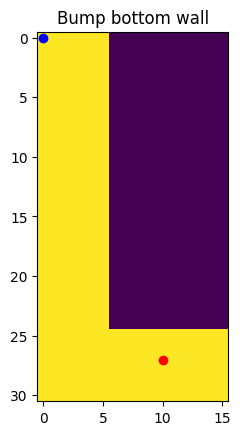

In [ ]:
# bump bottom wall
start_state = (10,27,3,4)
out =  next_step(start_state,(0,0))
plt.imshow(state_space)
plt.plot(*start_state[:2],'ro')
plt.plot(out[1],out[2],'bo')
plt.title("Bump bottom wall")
plt.show()


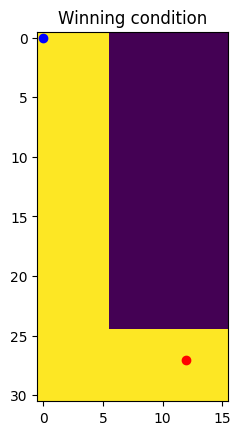

In [ ]:
# winning condition
start_state = (12,27,4,2)
out =  next_step(start_state,(0,0))
plt.imshow(state_space)
plt.plot(*start_state[:2],'ro')
plt.plot(out[1],out[2],'bo')
plt.title("Winning condition")
plt.show()
assert out == (1,0,0,0,0)

## Compute valid action space

In [ ]:
def compute_action_space(velocity: tuple[int,int]):
    actions = list(itertools.product(actions_horizontal, actions_vertical))
    if velocity[0] == 0:
        actions = [a for a in actions if a[0] != -1]
    if velocity[1] == 0:
        actions = [a for a in actions if a[1] != -1]
    if velocity[0] == 5:
        actions = [a for a in actions if a[0] != 1]
    if velocity[1] == 5:
        actions = [a for a in actions if a[1] != 1]
    return set(actions)

assert compute_action_space((0,0)) == {(0,0),(0,1),(1,0),(1,1)}
assert compute_action_space((0,1)) == {(0,0),(0,1),(1,0),(1,1),(0,-1),(1,-1)}
assert compute_action_space((1,0)) == {(0,0),(0,1),(1,0),(1,1),(-1,0),(-1,1)}
assert compute_action_space((5,5)) == {(0,0),(0,-1),(-1,0),(-1,-1)}
assert compute_action_space((1,1)) == set(itertools.product(actions_horizontal, actions_vertical))
compute_action_space((5,0))

{(-1, 0), (-1, 1), (0, 0), (0, 1)}